In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import tensorflow as tf
from keras import layers,Model
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout,InputLayer,Flatten,Dense,BatchNormalization,MaxPooling2D,Conv2D,Input,Concatenate,LeakyReLU
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical,normalize
from keras.applications.xception import Xception,preprocess_input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint,TensorBoard
import numpy as np
import joblib
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm_notebook as tqdm
import warnings
import keras.backend as K
import random
warnings.filterwarnings('ignore')

Load the .pkl file for train and CV containing the images array and their actual labels.

In [ ]:
#Path to the .pkl files for train and cv
x_train=joblib.load('/content/drive/MyDrive/Hashim/Final/x_train.pkl')
y_train=joblib.load('/content/drive/MyDrive/Hashim/Final/y_train.pkl')
y_cv=joblib.load('/content/drive/MyDrive/Hashim/Final/y_cv.pkl')
x_cv=joblib.load('/content/drive/MyDrive/Hashim/Final/x_cv.pkl')
print ("DONE")

DONE


In [ ]:
print("Shape of Train data {}".format(x_train.shape))
print("Shape of Cv data {}".format(x_cv.shape))


Shape of Train data (16126, 299, 299, 3)
Shape of Cv data (3952, 299, 299, 3)


Conversion of lables from test and cv to categorical to fit the shape of the output layer.

In [ ]:
#Conversion of lables from single array to shape(-1,2) for categorical output
Y_train=to_categorical(y_train)
Y_cv = to_categorical(y_cv)

In [ ]:
print (Y_train.shape)
print (Y_cv.shape)

(16126, 2)
(3952, 2)


# **The training of the model starts here. **
# The steps followed to train the model are as follow: **bold text**
1.  Import the Xception base model with imagenet weights without the final and polling layer.
2.  To fit the weights of the model, according to our training data, its hidden layer training is made True.
3.  Add global average and a new output layer with 2 outputs on top of the base model.
4.  Train the model for three epochs on our training data to adjust its weights.
5.  Freeze the weights of the model.
6.  Remove the output layer and replace it with the fresh output layer with 2 outputs.
7.  Train the model for another 15 epochs.
8.  Save the model and evaluate its performance.

In [ ]:
#Import Xception pretrained model with imagenet weights
base_model=Xception(include_top=False,
           weights='imagenet',
           input_shape=(299,299,3)
           )
# Unfreeze the base_model
base_model.trainable = True

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
#Creat a new model sequence
model = keras.Sequential()
#add base model to it
model.add(base_model)
#add average polling layer
model.add(keras.layers.GlobalAveragePooling2D())
#add new output layer with softmax activation
model.add(Dense(2,activation ='softmax'))


In [ ]:
#summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 20,811,050
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
#compile the model with parameters from FaceForensic++ paper hyperparameters
model.compile(loss=keras.losses.categorical_crossentropy,
          optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
          metrics=['accuracy'])
#Train the model on our traing data for 3 epochs to adjust irs weights
pretraining_Xception =model.fit(x_train, Y_train,
                                verbose=1,
                                batch_size=32,  
                                epochs=3)

Epoch 1/3
504/504 [==============================] - 238s 454ms/step - loss: 0.0885 - accuracy: 0.9608
Epoch 2/3
504/504 [==============================] - 228s 453ms/step - loss: 0.0085 - accuracy: 0.9984
Epoch 3/3
504/504 [==============================] - 228s 453ms/step - loss: 8.3071e-04 - accuracy: 0.9997


In [ ]:
#Freez the model
model.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 0
Non-trainable params: 20,865,578
_________________________________________________________________


In [ ]:
#Creat a new sequence model the previous model to it with out last output layer
model_post = keras.Sequential()
for layer in model.layers[:-1]: # go through until last layer
    model_post.add(layer)

#model_post.trainable = False
model_post.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 20,861,480
Trainable params: 0
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
#Add new output layer to new sequence
model_post.add(Dense(2, activation='softmax'))

In [ ]:
model_post.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
#Compile the new sequence using the same hyperparameters
model_post.compile(loss=keras.losses.categorical_crossentropy,
          optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
          metrics=['accuracy'])
#Train and evaluate the model for 15 epochs
finetuning_XceptionNet=model_post.fit(x_train, Y_train,verbose=1,batch_size=32,
                     epochs=15,
                     validation_data=(x_cv, Y_cv)
                      )

Epoch 1/15
504/504 [==============================] - 51s 97ms/step - loss: 0.0918 - accuracy: 0.9844 - val_loss: 0.1019 - val_accuracy: 0.9732
Epoch 2/15
504/504 [==============================] - 48s 95ms/step - loss: 0.0213 - accuracy: 0.9930 - val_loss: 0.0834 - val_accuracy: 0.9772
Epoch 3/15
504/504 [==============================] - 48s 95ms/step - loss: 0.0116 - accuracy: 0.9972 - val_loss: 0.0734 - val_accuracy: 0.9780
Epoch 4/15
504/504 [==============================] - 48s 95ms/step - loss: 0.0081 - accuracy: 0.9984 - val_loss: 0.0694 - val_accuracy: 0.9795
Epoch 5/15
504/504 [==============================] - 48s 95ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 0.0643 - val_accuracy: 0.9823
Epoch 6/15
504/504 [==============================] - 48s 95ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.0625 - val_accuracy: 0.9820
Epoch 7/15
504/504 [==============================] - 48s 95ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0583 - val_accuracy:

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


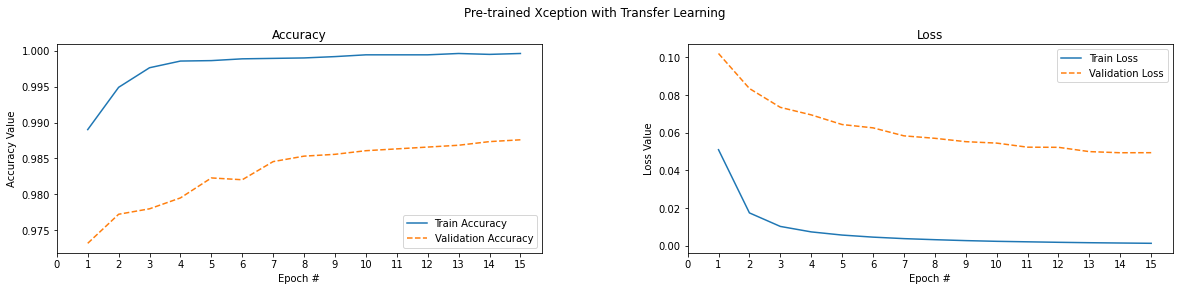

In [ ]:
#Plot the training and evaluation accuracy and loss curves
i =0
EPOCHS = 15
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained Xception with Transfer Learning ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))

print (epoch_list)
ax1.plot(epoch_list, finetuning_XceptionNet.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, finetuning_XceptionNet.history['val_accuracy'], label='Validation Accuracy',linestyle='dashed')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, finetuning_XceptionNet.history['loss'], label='Train Loss')
ax2.plot(epoch_list, finetuning_XceptionNet.history['val_loss'], label='Validation Loss',linestyle='dashed')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
#Save the model
model_post.save("/content/drive/MyDrive/Hashim/MXXCEPTIONFINALMODEL/Xception Fnal Last ry/model_finetuned_xception.hdf5")

Save the training parameters to a csv file

In [ ]:
import pandas as pd

pd.DataFrame.from_dict(finetuning_XceptionNet.history).to_csv('/content/drive/MyDrive/Hashim/MXXCEPTIONFINALMODEL/Xception Fnal Last ry/history variables.csv',index=False)

In [ ]:
#Evaluate model performance on train data
model_post.evaluate(x_train,Y_train)

504/504 [==============================] - 39s 76ms/step - loss: 0.0012 - accuracy: 0.9998


[0.0012105836067348719, 0.9997519254684448]

Evaluate model performance on cv data

In [ ]:
model_post.evaluate(x_cv,Y_cv)

124/124 [==============================] - 10s 76ms/step - loss: 0.0494 - accuracy: 0.9876


[0.04936504364013672, 0.9876012206077576]

# **Cration of confusion matrix for the training and CV data**

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [ ]:
model_Xc1 = models.load_model('/content/drive/MyDrive/Hashim/MXXCEPTIONFINALMODEL/Xception Fnal Last ry/model_finetuned_xception.hdf5')

True positive =  982
False positive =  28
False negative =  21
True negative =  2921




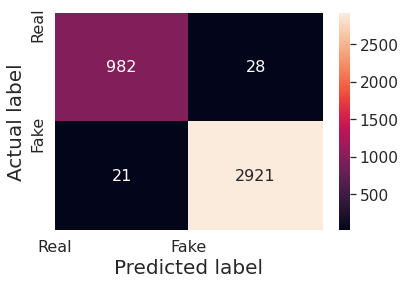

In [ ]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Real', 'Fake'], size = 16)
    plt.yticks(np.arange(2), ['Real', 'Fake'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(y_cv, model_Xc1.predict_classes(x_cv))